In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
extent = Kara['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [8]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [9]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 212ms/step - loss: 0.6360 - root_mean_squared_error: 0.7975 - val_loss: 0.4670 - val_root_mean_squared_error: 0.6834
Epoch 2/50
53/53 [==============================] - 10s 200ms/step - loss: 0.3363 - root_mean_squared_error: 0.5799 - val_loss: 0.1524 - val_root_mean_squared_error: 0.3903
Epoch 3/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0967 - root_mean_squared_error: 0.3110 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3784
Epoch 4/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0882 - root_mean_squared_error: 0.2970 - val_loss: 0.1291 - val_root_mean_squared_error: 0.3593
Epoch 5/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0769 - root_mean_squared_error: 0.2773 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3411
Epoch 6/50
53/53 [==============================] - 10s 193ms/step - loss: 0.0682 - root_mean_squared_error: 0.2612 - val_loss: 0.1042 

In [10]:
time = (etime - stime)/60
print(f'{time} minutes')

6.254505439599355 minutes


In [11]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

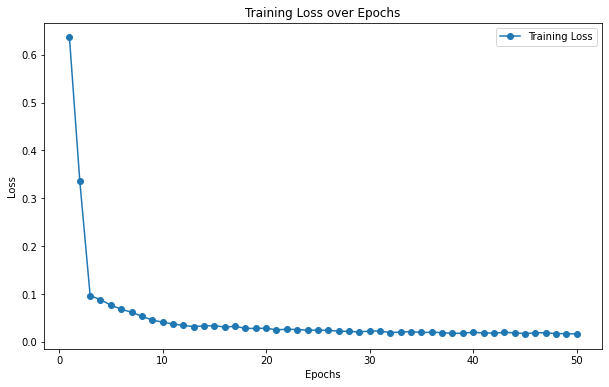

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

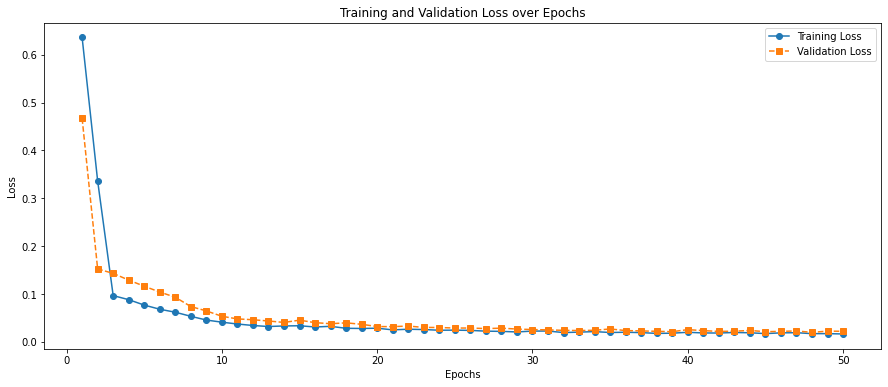

In [13]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.14715309318208428
MAE : 0.10632624583039883


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,912836.937500,893583.864
1,886339.812500,763496.585
2,311241.500000,282691.615
3,181652.468750,71897.386
4,211624.031250,60592.380
5,296253.968750,131973.043
6,550444.250000,753595.099
7,722086.625000,909176.475
8,836762.562500,917006.278
9,875288.062500,906368.363


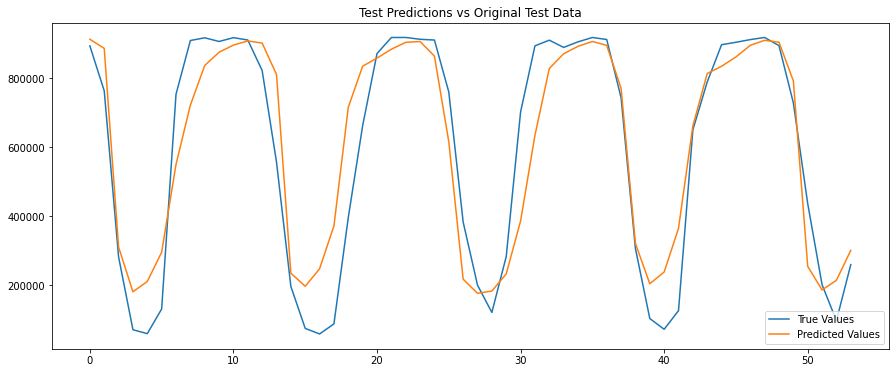

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 8ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

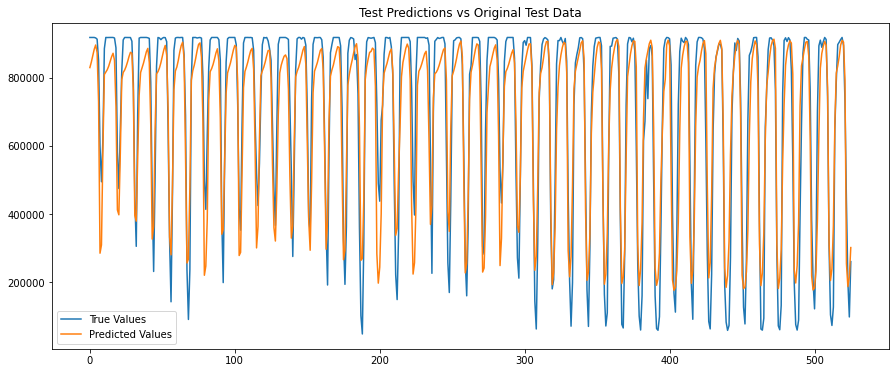

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()